#Projeto Final - Big Data - G5

- Alexandre Krausz
- Beatriz Lavia
- Felipe Castelar
- Gabriel Muller

<img src="https://static1.simpleflyingimages.com/wordpress/wp-content/uploads/2023/01/psa-aa.jpg" width="500">

#Introdução
O trabalho utiliza dados relativos a voo's nos EUA entre 2009 e 2018 e busca responder à seguinte pergunta: após o avião partir, ele chegará atrasado no destino? Dessa forma,o  modelo suporta decisões como trocar a ordem de chegada dos aviões ou decidir por trocar o aeroporto de destino.

A base de dados foi filtrada entre as companhias com maior média de atrasos, entre aquelas com mais de 100 mil dados registrados. Além disso, entre os aeroportos de destino com mais atrasos, aos quais o modelo será mais relevante.

Por fim, foram testados modelos de regressão logística e floresta aleatória, com e sem otimização de hiperparâmetros. O modelo escolhido foi a floresta aleatória com otimização de hiperparâmetros, que obteve maior sensibilidade e acurácia.

#Importar bibliotecas e arquivo

In [0]:
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.sql.functions import mean, count, col, floor, concat_ws
from pyspark.sql.functions import date_trunc, when, date_format, dayofweek, year, month, to_date, date_format

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master("local[4]") \
            .appName("nyc_<mudar-nome>") \
            .getOrCreate()

In [0]:
df_0 = spark.read.csv("/FileStore/tables/base_projeto_integrador_bigdata/*.csv", header=True, inferSchema=True)
#airline_delay_2009

Separamos os dataframes para uso e análise:

In [0]:
df = df_0.sample(fraction=0.05, seed=42)

In [0]:
sample_df = df_0.sample(fraction=0.05, seed=42)

#Visualização dos dados nulos

A função percentage_missing_rdd calcula a % de dados faltantes por coluna, utilizanndo RDD e operações de transformação e ação.

In [0]:
def percentage_missing_rdd(df):
    rdd = df.rdd
    total_count = rdd.count()
    
    column_names = df.columns  # Captura no driver

    def count_nulls(row):
        return [
            (column_names[i], 1 if row[i] is None else 0)
            for i in range(len(column_names))
        ]

    # Conta nulos por coluna
    missing_counts = rdd.flatMap(count_nulls) \
                        .reduceByKey(lambda a, b: a + b) \
                        .collect()

    # Calcula a porcentagem
    missing_percentages = {
        col: (count / total_count) * 100 for col, count in missing_counts
    }

    return missing_percentages

missing_percentages = percentage_missing_rdd(df)
for col_name, percent in missing_percentages.items():
    print(f"Coluna '{col_name}': {percent:.2f}% ausente")

Coluna 'DIVERTED': 0.00% ausente
Coluna 'CARRIER_DELAY': 81.55% ausente
Coluna 'ORIGIN': 0.00% ausente
Coluna 'OP_CARRIER': 0.00% ausente
Coluna 'WHEELS_OFF': 1.57% ausente
Coluna 'CANCELLED': 0.00% ausente
Coluna 'CRS_ELAPSED_TIME': 0.00% ausente
Coluna 'DISTANCE': 0.00% ausente
Coluna 'WEATHER_DELAY': 81.55% ausente
Coluna 'SECURITY_DELAY': 81.55% ausente
Coluna 'ARR_DELAY': 1.82% ausente
Coluna 'DEST': 0.00% ausente
Coluna 'FL_DATE': 0.00% ausente
Coluna 'CANCELLATION_CODE': 98.42% ausente
Coluna 'CRS_ARR_TIME': 0.00% ausente
Coluna 'OP_CARRIER_FL_NUM': 0.00% ausente
Coluna 'AIR_TIME': 1.82% ausente
Coluna 'LATE_AIRCRAFT_DELAY': 81.55% ausente
Coluna 'DEP_TIME': 1.52% ausente
Coluna 'WHEELS_ON': 1.62% ausente
Coluna 'ARR_TIME': 1.62% ausente
Coluna 'DEP_DELAY': 1.52% ausente
Coluna 'ACTUAL_ELAPSED_TIME': 1.82% ausente
Coluna 'Unnamed: 27': 100.00% ausente
Coluna 'CRS_DEP_TIME': 0.00% ausente
Coluna 'TAXI_OUT': 1.57% ausente
Coluna 'TAXI_IN': 1.62% ausente
Coluna 'NAS_DELAY': 81.55% 

#Análise Exploratória

## Preparo dos dados

A partir da visualização dos dados nulos, as colunas com alta porcentagem de dados ausentes foram exluídas. Como as outras variáveis apresentaram porcentagens baixas de dados faltantes, após a exclusão das primeiras, excluimos linhas vazias e duplicadas.

In [0]:
columns_to_drop = [
    "CANCELLATION_CODE",
    "CARRIER_DELAY",
    "WEATHER_DELAY",
    "NAS_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "DIVERTED",
    "Unnamed: 27"
]

# Excluir colunas e linhas vazias
sample_df = sample_df.drop(*columns_to_drop)
sample_df = sample_df.dropna()

#Excluir dados duplicados
sample_df = sample_df.dropDuplicates()



Para a análise exploratória, criamos colunas auxiliares:
- Mês 
- Ano
- Atraso
- Hora de decolagem
- Rota
- Final de Semana
- Estação

Como estamos trabalhando apenas com os atrasos, os voos cancelados foram excluídos da base.

In [0]:
# Excluir voos cancelados
sample_df = sample_df.filter(sample_df["CANCELLED"] == 0)

# Preparar coluna de datas e criar colunas auxiliares
sample_df = sample_df.withColumn('month', f.date_trunc("month", sample_df.FL_DATE))
sample_df = sample_df.withColumn("FL_DATE", to_date("FL_DATE"))

sample_df = sample_df.withColumn("Year", year("FL_DATE")) \
            .withColumn("Month", month("FL_DATE")) \
            .withColumn("DAY_OF_WEEK", date_format("FL_DATE", "EEEE")) \
            .withColumn("DELAYED", when(sample_df.ARR_DELAY >= 15, (1.0)).otherwise(0.0)) \
            .withColumn("DEP_HOUR", floor(col("CRS_DEP_TIME") / 100)) \
            .withColumn("ROUTE", concat_ws("-", "ORIGIN", "DEST")) 


In [0]:
sample_df = sample_df.withColumn("IS_WEEKEND", when(sample_df.DAY_OF_WEEK.isin(["Saturday", "Sunday"]), 1.0).otherwise(0.0))

sample_df = sample_df.withColumn(
    "SEASON",
    when(col("Month").isin(12, 1, 2), "Winter")
    .when(col("Month").isin(3, 4, 5), "Spring")
    .when(col("Month").isin(6, 7, 8), "Summer")
    .otherwise("Fall")
)

## Empresas x volume de voos / atrasos

Visualização das empresas aéreas mais comuns por volume de voos e dos atrasos por empresa.

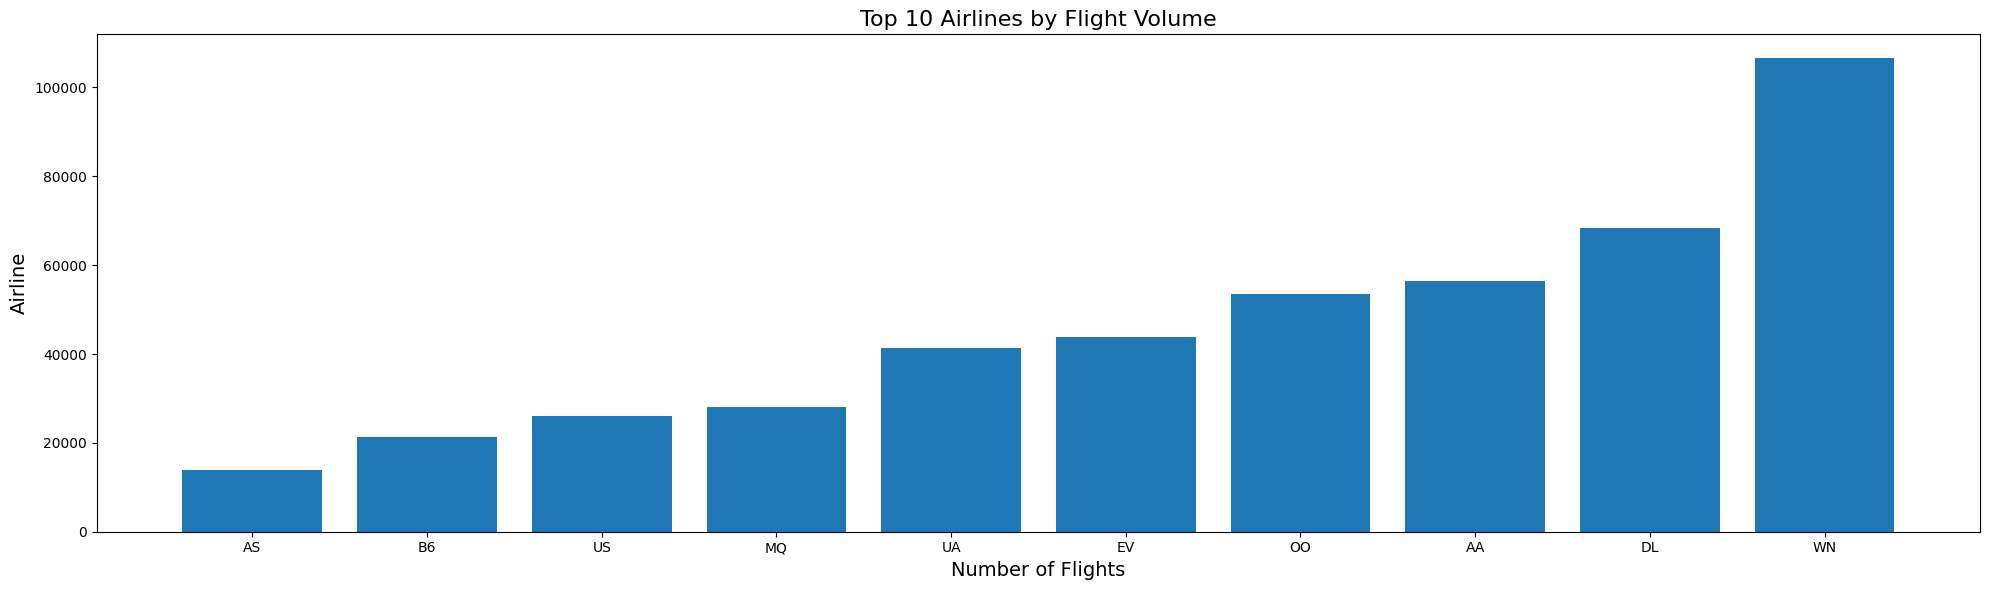

In [0]:
# Contar voos por empresa e limitar aos 10 maiores
top_airlines = (sample_df.groupBy('OP_CARRIER').count().orderBy('count', ascending=False).limit(10))

# Conversão para pandas
top_airlines_pd = top_airlines.toPandas()

# Organizar ordem
top_airlines_pd = top_airlines_pd.sort_values("count", ascending=True)

# Plot
plt.figure(figsize=(20, 6))
plt.bar(top_airlines_pd["OP_CARRIER"],top_airlines_pd["count"])
plt.title("Top 10 Airlines by Flight Volume", fontsize=16)
plt.xlabel("Number of Flights", fontsize=14)
plt.ylabel("Airline", fontsize=14)
plt.tight_layout()
plt.show()


<Figure size 2000x600 with 0 Axes>

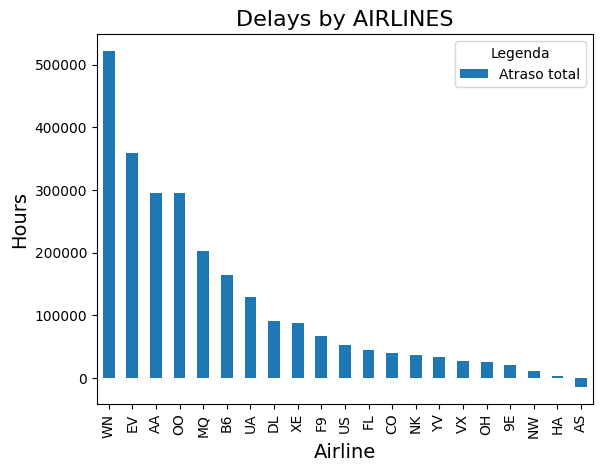

In [0]:
# Agrupar por empresa e somar atrasos
airline_agg = sample_df.groupby('OP_CARRIER').agg({'ARR_DELAY': 'sum'})

# Organizar por atrasos
airline_agg = airline_agg.orderBy('sum(ARR_DELAY)', ascending=False)

# Pandas
airline_agg_df = airline_agg.toPandas()

# Plotting
plt.figure(figsize=(20, 6))
airline_agg_df.plot.bar(x='OP_CARRIER', y='sum(ARR_DELAY)',label="Atraso total")
plt.title('Delays by AIRLINES', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Hours', fontsize=14)
plt.legend(title="Legenda")
plt.show()

## Voos x meses x anos

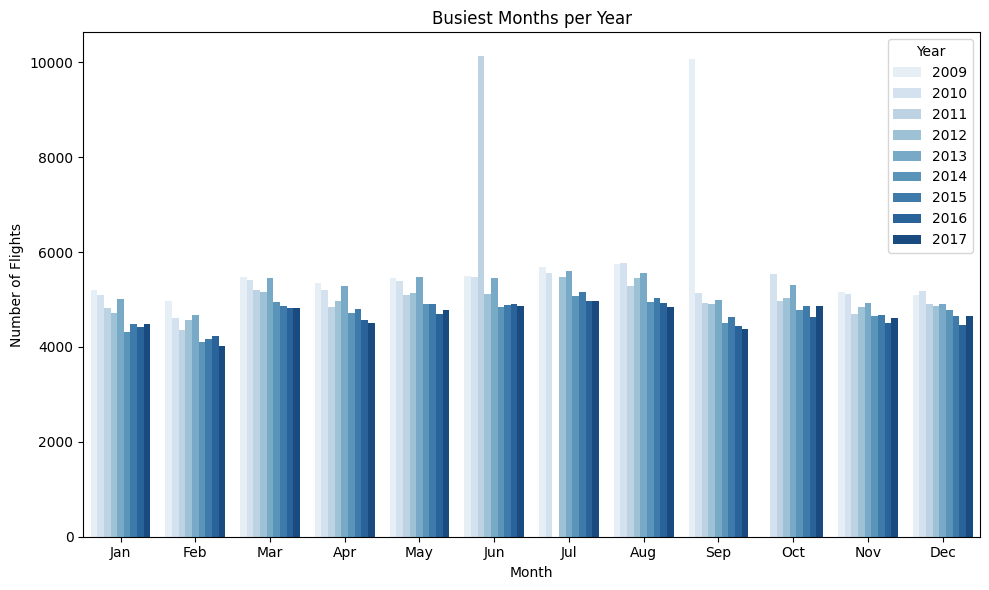

In [0]:
# Contagem de voos mensais por ano
monthly_flights = (
    sample_df.groupBy("Year", "Month")
    .count()
    .withColumnRenamed("count", "Flight Count")
    .orderBy("Year", "Month")
)

# Pandas
monthly_flights_pd = monthly_flights.toPandas()

# Paleta
years = sorted(monthly_flights_pd["Year"].unique())
blue_palette = sns.color_palette("Blues", n_colors=len(years))

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_flights_pd, x='Month', y='Flight Count', hue='Year', palette=blue_palette)
plt.title('Busiest Months per Year')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.tight_layout()
plt.show()


## Atrasos x chegada / saída

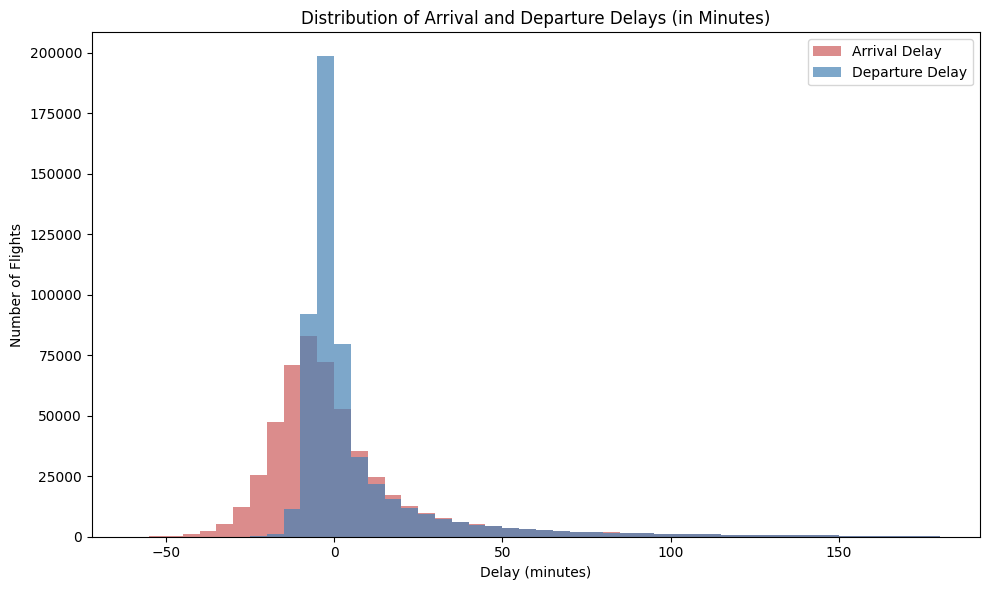

In [0]:
# Selecionar colunas relevantes e converter para Pandas
delay_pd = sample_df.select("ARR_DELAY", "DEP_DELAY").toPandas()

plt.figure(figsize=(10, 6))

# Histogramas
plt.hist(delay_pd["ARR_DELAY"], bins=range(-60, 185, 5), alpha=0.7, label="Arrival Delay", color="indianred")
plt.hist(delay_pd["DEP_DELAY"], bins=range(-60, 185, 5), alpha=0.7, label="Departure Delay", color="steelblue")

# Layout do gráfico
plt.title("Distribution of Arrival and Departure Delays (in Minutes)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Number of Flights")
plt.legend()
plt.tight_layout()
plt.show()


## Atraso médio por empresa

/root/.ipykernel/984/command-5558836993142485-2063281627:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


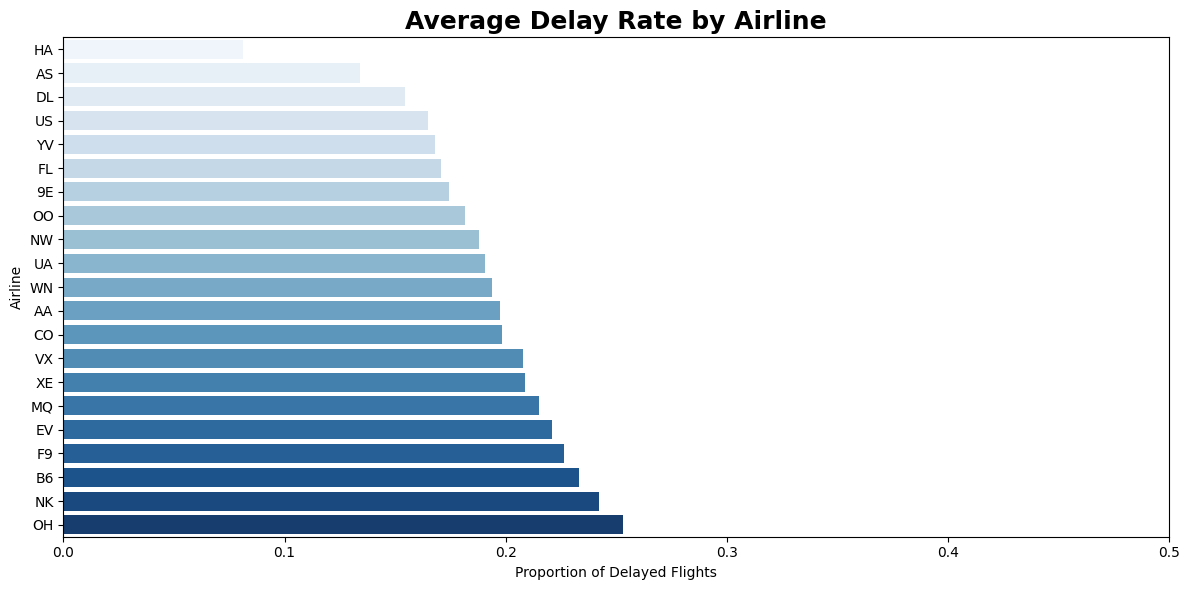

In [0]:
# Cálculo do atraso médio
airline_delay = (
    sample_df.groupBy("OP_CARRIER")
    .agg(mean("DELAYED").alias("DELAYED"))
    .orderBy("DELAYED")
)

# Pandas
airline_delay_pd = airline_delay.toPandas()

# Organização dos dados
airline_delay_pd = airline_delay_pd.sort_values("DELAYED", ascending=True)

# Paleta de cores
palette = sns.color_palette("Blues", n_colors=len(airline_delay_pd))

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=airline_delay_pd,
    x="DELAYED",
    y="OP_CARRIER",
    palette=palette
)

plt.title("Average Delay Rate by Airline", fontsize=18, weight='bold')
plt.xlabel("Proportion of Delayed Flights")
plt.ylabel("Airline")
plt.xlim(0, 0.5)
plt.tight_layout()
plt.show()


## Distância x atraso

In [0]:

# Selecionar atrasos de até 300 minutos, excluindo outliers e melhorando processamento
sample_df = sample_df.withColumn("ARR_DELAY_CAPPED", when(col("ARR_DELAY") > 300, 300).otherwise(col("ARR_DELAY")))

# Criação da legenda
sample_df = sample_df.withColumn(
    "DELAY_STATUS",
    when(col("DELAYED") == 1, "Delayed (>=15 min)").otherwise("On Time (<15 min)")
)

# Selecionar colunas relevantes
plot_df = sample_df.select("DISTANCE", "ARR_DELAY_CAPPED", "DELAY_STATUS")

# Pandas
plot_pd = plot_df.toPandas()


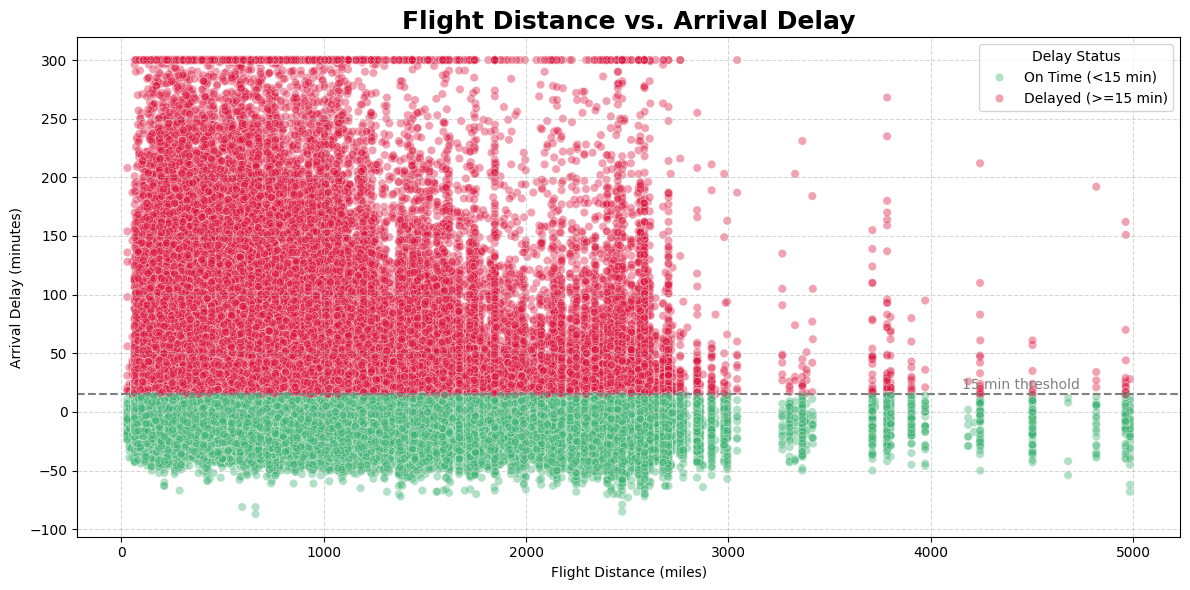

In [0]:

plt.figure(figsize=(12, 6))

# Scatterplot
sns.scatterplot(
    data=plot_pd,
    x="DISTANCE",
    y="ARR_DELAY_CAPPED",
    hue="DELAY_STATUS",
    alpha=0.4,
    palette={
        "On Time (<15 min)": "mediumseagreen",
        "Delayed (>=15 min)": "crimson"
    }
)

# Linha de marcação dos 15 minutos
plt.axhline(15, color='gray', linestyle='--', linewidth=1.5)
plt.text(plot_pd["DISTANCE"].max() * 0.95, 20, '15 min threshold', color='gray', ha='right')

# Layout
plt.title("Flight Distance vs. Arrival Delay", fontsize=18, weight='bold')
plt.xlabel("Flight Distance (miles)")
plt.ylabel("Arrival Delay (minutes)")
plt.legend(title="Delay Status")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Atrasos x mês / hora

In [0]:

# Taxa de atraso por mês
monthly_delay = (
    sample_df.groupBy("Month")
    .agg(mean("DELAYED").alias("DELAYED"))
    .orderBy("Month")
)

# Taxa de atraso por hora de decolagem
hourly_delay = (
    sample_df.groupBy("DEP_HOUR")
    .agg(mean("DELAYED").alias("DELAYED"))
    .orderBy("DEP_HOUR")
)

# Pandas
monthly_delay_pd = monthly_delay.toPandas()
hourly_delay_pd = hourly_delay.toPandas()


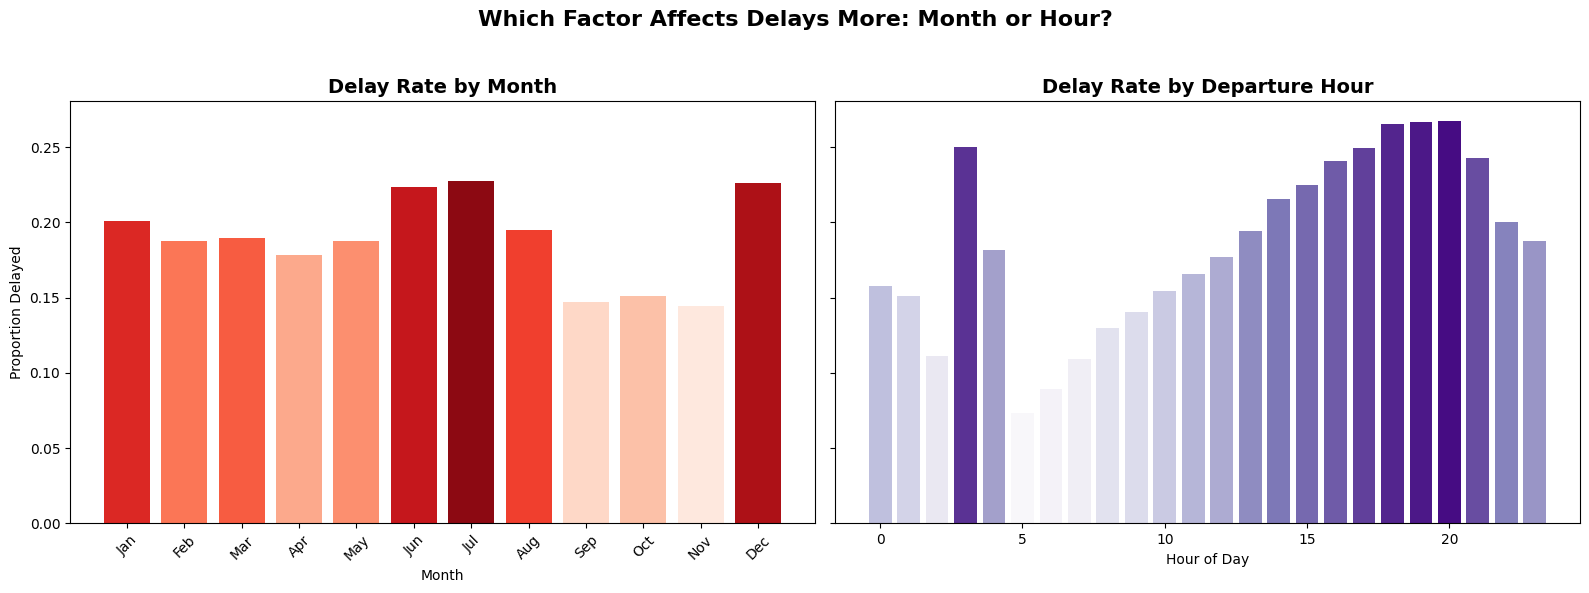

In [0]:
import seaborn as sns

# Ranking
monthly_delay_pd["rank"] = monthly_delay_pd["DELAYED"].rank(method="first").astype(int)
hourly_delay_pd["rank"] = hourly_delay_pd["DELAYED"].rank(method="first").astype(int)

# Paletas de cor
month_colors = sns.color_palette("Reds", n_colors=12)
hour_colors = sns.color_palette("Purples", n_colors=24)

# Mapear cores de acordo com o ranking
monthly_delay_pd["color"] = monthly_delay_pd["rank"].apply(lambda i: month_colors[i - 1])
hourly_delay_pd["color"] = hourly_delay_pd["rank"].apply(lambda i: hour_colors[i - 1])

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plotar mês
axes[0].bar(
    monthly_delay_pd["Month"],
    monthly_delay_pd["DELAYED"],
    color=monthly_delay_pd["color"]
)
axes[0].set_title("Delay Rate by Month", fontsize=14, weight="bold")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Proportion Delayed")
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Plotar hora
axes[1].bar(
    hourly_delay_pd["DEP_HOUR"],
    hourly_delay_pd["DELAYED"],
    color=hourly_delay_pd["color"]
)
axes[1].set_title("Delay Rate by Departure Hour", fontsize=14, weight="bold")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")

# Layout
plt.suptitle("Which Factor Affects Delays More: Month or Hour?", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Hora x dia da semana x atraso

In [0]:
# Extrair hora de decolagem
sample_df = sample_df.withColumn("CRS_DEP_HOUR", floor(col("CRS_DEP_TIME") / 100))

# Reorganizar o dayofweek do Spark (1=Sun, 7=Sat) para (0=Mon, 6=Sun)
sample_df = sample_df.withColumn("DAY_OF_WEEK", ((dayofweek("FL_DATE") + 5) % 7))

# Atraso de chegada médio por dia e hora
heatmap_df = (
    sample_df.groupBy("DAY_OF_WEEK", "CRS_DEP_HOUR")
    .agg(mean("ARR_DELAY").alias("AVG_ARR_DELAY"))
    .orderBy("DAY_OF_WEEK", "CRS_DEP_HOUR")
)

# Pandas
heatmap_pd = heatmap_df.toPandas()

# Pivotar para criar matriz para o mapa de calor
heatmap_matrix = heatmap_pd.pivot(index="DAY_OF_WEEK", columns="CRS_DEP_HOUR", values="AVG_ARR_DELAY")

# Organizar por dia da semana
heatmap_matrix = heatmap_matrix.sort_index()


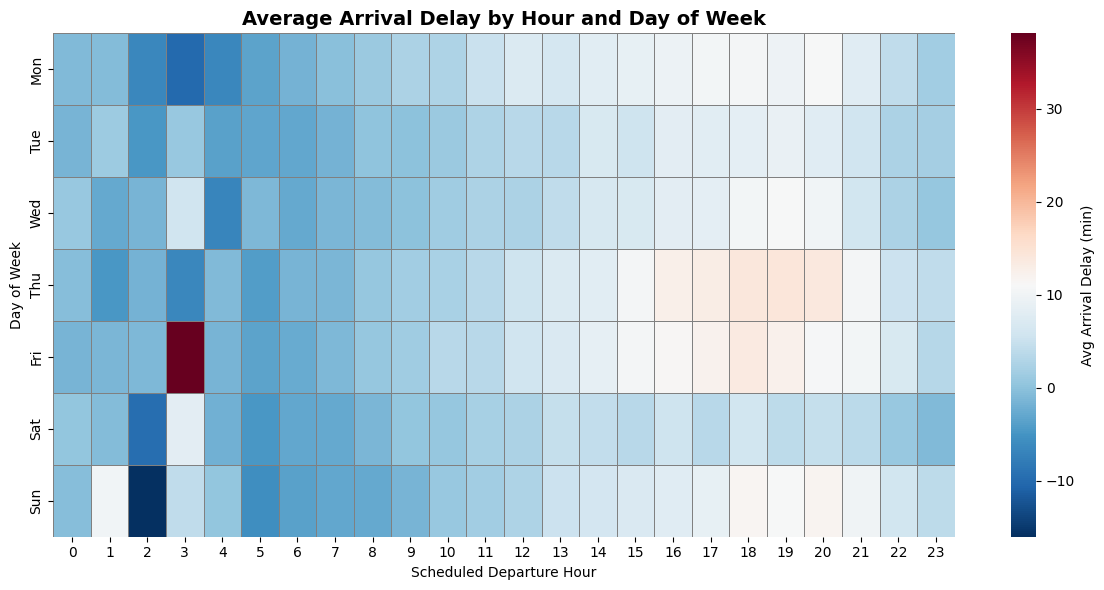

In [0]:
# Legendas
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_matrix,
    cmap="RdBu_r",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Avg Arrival Delay (min)"},
    xticklabels=True,
    yticklabels=day_labels
)

plt.title("Average Arrival Delay by Hour and Day of Week", fontsize=14, weight="bold")
plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


## Atrasos na semana

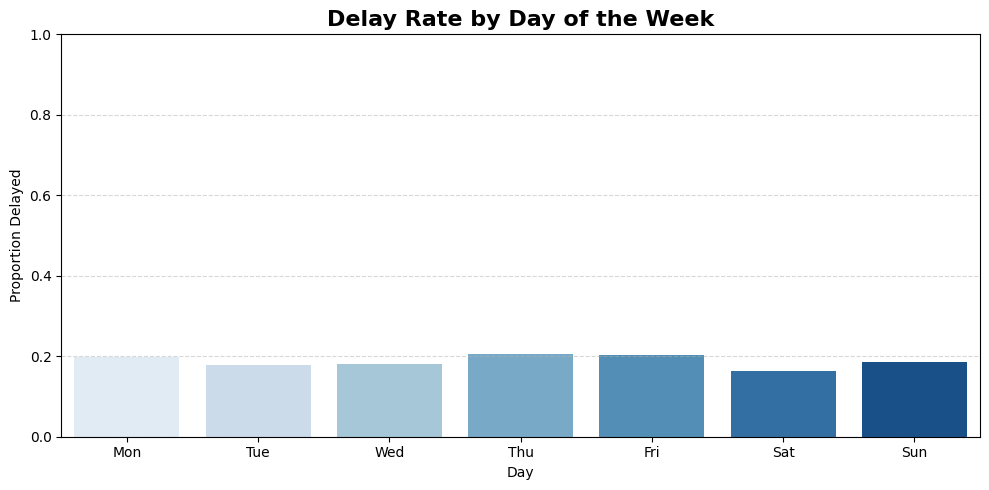

In [0]:
# Taxa de atraso por dia da semana
dow_delay = (
    sample_df.groupBy("DAY_OF_WEEK")
    .agg(mean("DELAYED").alias("DELAYED"))
    .orderBy("DAY_OF_WEEK")
)

# Pandas
dow_delay_pd = dow_delay.toPandas()

# Paleta
palette = sns.color_palette("Blues", n_colors=len(day_labels))

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=dow_delay_pd,
    x="DAY_OF_WEEK",
    y="DELAYED",
    palette=palette,
    hue="DAY_OF_WEEK",
    legend=False
)

# Renomear x
plt.xticks(ticks=range(len(day_labels)), labels=day_labels)

# Layout
plt.title("Delay Rate by Day of the Week", fontsize=16, weight="bold")
plt.xlabel("Day")
plt.ylabel("Proportion Delayed")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Semana útil x fim de semana

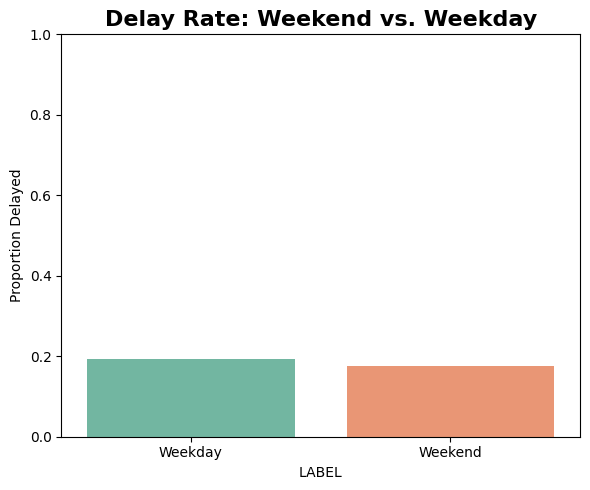

In [0]:
# Taxa de atraso
weekend_delay = (
    sample_df.groupBy("IS_WEEKEND")
    .agg(mean("DELAYED").alias("DELAYED"))
    .orderBy("IS_WEEKEND")
)

# Pandas
weekend_delay_pd = weekend_delay.toPandas()

# Legendas
weekend_delay_pd["LABEL"] = weekend_delay_pd["IS_WEEKEND"].map({0: "Weekday", 1: "Weekend"})

# Paleta
palette = sns.color_palette("Set2", n_colors=len(weekend_delay_pd))

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(
    data=weekend_delay_pd,
    x="LABEL",
    y="DELAYED",
    hue="LABEL",
    palette=palette,
    legend=False
)

# Layout
plt.title("Delay Rate: Weekend vs. Weekday", fontsize=16, weight="bold")
plt.ylabel("Proportion Delayed")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## Atraso por estação

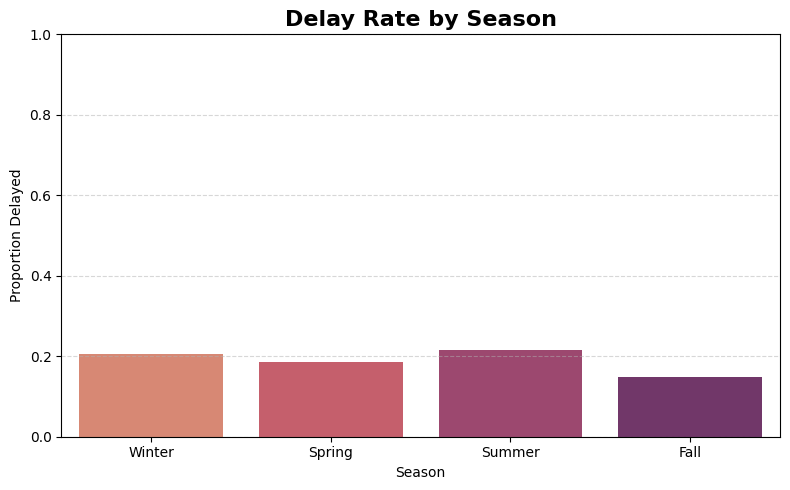

In [0]:
# Taxa de atraso
season_delay = (
    sample_df.groupBy("SEASON")
    .agg(mean("DELAYED").alias("DELAYED"))
)

# Pandas
season_delay_pd = season_delay.toPandas()

# Organizar estações
season_order = ["Winter", "Spring", "Summer", "Fall"]
season_delay_pd = season_delay_pd.set_index("SEASON").reindex(season_order).reset_index()

# Paleta
palette = sns.color_palette("flare", n_colors=len(season_delay_pd))

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=season_delay_pd,
    x="SEASON",
    y="DELAYED",
    hue="SEASON",
    palette=palette,
    legend=False
)

# Layout
plt.title("Delay Rate by Season", fontsize=16, weight="bold")
plt.xlabel("Season")
plt.ylabel("Proportion Delayed")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Principais rotas

Utilizando uma base externa com as coordenadas de latitude e longitude dos aeroportos, criamos visualizações geoespaciais.

In [0]:
# Carregar base de coordenadas
airports = spark.read.csv("/FileStore/tables/airports.csv", 
                          header=True, 
                          inferSchema=True)

# Selecionar e renomear colunas relevantes
airports = airports.select("iata", "lat", "long") \
                   .dropna() \
                   .withColumnRenamed("iata", "IATA_CODE") \
                   .withColumnRenamed("lat", "LATITUDE") \
                   .withColumnRenamed("long", "LONGITUDE")

In [0]:
# Preparar aeroportos de origem
origin_coords = airports.withColumnRenamed("IATA_CODE", "ORIGIN") \
                        .withColumnRenamed("LATITUDE", "ORIGIN_LAT") \
                        .withColumnRenamed("LONGITUDE", "ORIGIN_LON")

# Junção ao dataframe de análise
sample_df = sample_df.join(origin_coords, on="ORIGIN", how="left")


In [0]:
# Aeroportos de destino
dest_coords = airports.withColumnRenamed("IATA_CODE", "DEST") \
                      .withColumnRenamed("LATITUDE", "DEST_LAT") \
                      .withColumnRenamed("LONGITUDE", "DEST_LON")

# Join
sample_df = sample_df.join(dest_coords, on="DEST", how="left")


In [0]:
# Agrupar por rotas e contar
routes = (
    sample_df.groupBy("ORIGIN", "DEST", "ORIGIN_LAT", "ORIGIN_LON", "DEST_LAT", "DEST_LON")
    .count()
    .withColumnRenamed("count", "ROUTE_COUNT")
)
# Organizar e limitar 100 principais
top_routes = routes.orderBy("ROUTE_COUNT", ascending=False).limit(100)

# Renomear colunas de origem e destino para a junção
origin_airports = top_routes.selectExpr(
    "ORIGIN as IATA", "ORIGIN_LAT as Lat", "ORIGIN_LON as Lon"
)

dest_airports = top_routes.selectExpr(
    "DEST as IATA", "DEST_LAT as Lat", "DEST_LON as Lon"
)

# Juntar e excluir duplicados
airports_df = origin_airports.union(dest_airports).dropDuplicates(["IATA"])


In [0]:

# Pandas
top_routes_pd = top_routes.toPandas()
airports_df_pd = airports_df.toPandas()

fig = go.Figure()

# Linhas representando rotas
for _, row in top_routes_pd.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        lon=[row["ORIGIN_LON"], row["DEST_LON"]],
        lat=[row["ORIGIN_LAT"], row["DEST_LAT"]],
        mode='lines',
        line=dict(width=1, color='blue'),
        opacity=0.4,
    ))

# Pontos representando aeroportos
fig.add_trace(go.Scattergeo(
    lon=airports_df_pd["Lon"],
    lat=airports_df_pd["Lat"],
    text=airports_df_pd["IATA"],  # IATA codes as labels
    mode='markers+text',
    textposition='top center',
    marker=dict(size=5, color='red'),
    showlegend=False
))


fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),  # left, right, top, bottom
    title_text='Top 100 U.S. Flight Routes (2017–2018 Sample, Including Alaska)',
    showlegend=False,
    geo=dict(
        projection_type='natural earth',  # Shows the full globe
        showland=True,
        showcountries=True,
        landcolor='rgb(243, 243, 243)',
        subunitcolor='rgb(217, 217, 217)',
        countrycolor='rgb(204, 204, 204)',
        coastlinecolor='rgb(204, 204, 204)',
        lataxis=dict(range=[10, 75]),     # Adjust latitude range to include Alaska
        lonaxis=dict(range=[-170, -50]),  # Adjust longitude range to include Alaska
    )
)
fig.update_traces(textfont=dict(size=9))  # Adjust label size if needed

fig.show()


## Maior proporção de atrasos

In [0]:

# Agrupar por destino
delay_rate = (
    sample_df.groupBy("DEST", "DEST_LAT", "DEST_LON")
    .agg(
        mean("DELAYED").alias("DELAY_RATE"),
        count("DELAYED").alias("NUM_FLIGHTS")
    )
    .withColumnRenamed("DEST", "IATA_CODE")
    .withColumnRenamed("DEST_LAT", "LATITUDE")
    .withColumnRenamed("DEST_LON", "LONGITUDE")
)


In [0]:

# Destinos com maior proporção de atrasos
top10_delay_rate = delay_rate.orderBy("DELAY_RATE", ascending=False).limit(10)

# Pandas
top10_delay_rate_pd = top10_delay_rate.toPandas()

fig = go.Figure()

# Add airport bubbles
fig.add_trace(go.Scattergeo(
    lon=top10_delay_rate_pd["LONGITUDE"],
    lat=top10_delay_rate_pd["LATITUDE"],
    text=top10_delay_rate_pd["IATA_CODE"],
    mode='markers+text',
    textposition='top center',
    marker=dict(
        size=top10_delay_rate_pd["DELAY_RATE"] * 100,  # Scale for visibility
        color=top10_delay_rate_pd["DELAY_RATE"],
        colorscale='Reds',
        colorbar=dict(title="Delay Rate"),
        line=dict(width=0.5, color='gray'),
        sizemode='area',
        sizeref=2.*max(top10_delay_rate_pd["DELAY_RATE"]*100)/100**2,
        sizemin=4
    ),
    showlegend=False
))

# Layout
fig.update_layout(
    title_text='Top 10 U.S. Airports by Proportion of Delayed Flights)',
    margin=dict(l=0, r=0, t=30, b=0),
    geo=dict(
        projection_type='natural earth',
        showland=True,
        showcountries=True,
        landcolor='rgb(243, 243, 243)',
        subunitcolor='rgb(217, 217, 217)',
        countrycolor='rgb(204, 204, 204)',
        coastlinecolor='rgb(204, 204, 204)',
        lataxis=dict(range=[10, 75]),
        lonaxis=dict(range=[-170, -50]),
    )
)

fig.update_traces(textfont=dict(size=9))
fig.show()


## Clusterização de regiões

In [0]:
sample_df.columns

['DEST',
 'ORIGIN',
 'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'Year',
 'Month',
 'DAY_OF_WEEK',
 'DELAYED',
 'DEP_HOUR',
 'ROUTE',
 'IS_WEEKEND',
 'SEASON',
 'ARR_DELAY_CAPPED',
 'DELAY_STATUS',
 'CRS_DEP_HOUR',
 'ORIGIN_LAT',
 'ORIGIN_LON',
 'DEST_LAT',
 'DEST_LON',
 'origin_features',
 'dest_features']

In [0]:
sample_df = sample_df.dropna(subset=["ORIGIN_LAT", "ORIGIN_LON", "DEST_LAT", "DEST_LON"])


# Assemble origin coordinates
origin_assembler = VectorAssembler(inputCols=["ORIGIN_LAT", "ORIGIN_LON"], outputCol="origin_features", handleInvalid="skip")
sample_df = origin_assembler.transform(sample_df)

# Assemble destination coordinates
dest_assembler = VectorAssembler(inputCols=["DEST_LAT", "DEST_LON"], outputCol="dest_features", handleInvalid="skip")
sample_df = dest_assembler.transform(sample_df)


# Cluster origin airports
kmeans_origin = KMeans(k=4, seed=42, featuresCol="origin_features", predictionCol="ORIGIN_REGION")
model_origin = kmeans_origin.fit(sample_df)
sample_df = model_origin.transform(sample_df)

# Cluster destination airports
kmeans_dest = KMeans(k=4, seed=42, featuresCol="dest_features", predictionCol="DEST_REGION")
model_dest = kmeans_dest.fit(sample_df)
sample_df = model_dest.transform(sample_df)


In [0]:
# Excluir duplicados
origin_clusters = (
    sample_df.select("ORIGIN", "ORIGIN_LAT", "ORIGIN_LON", "ORIGIN_REGION")
    .dropna()
    .dropDuplicates(["ORIGIN", "ORIGIN_LAT", "ORIGIN_LON", "ORIGIN_REGION"])
)

#Pandas
origin_clusters_pd = origin_clusters.toPandas()
origin_clusters_pd.columns = ["IATA", "LAT", "LON", "CLUSTER"]


In [0]:
fig = go.Figure()
cluster_colors = ['red', 'blue', 'green', 'orange']  # Uma cor por cluster

# Plot
for cluster_id in sorted(origin_clusters_pd["CLUSTER"].unique()):
    cluster_data = origin_clusters_pd[origin_clusters_pd["CLUSTER"] == cluster_id]
    
    fig.add_trace(go.Scattergeo(
        lon=cluster_data["LON"],
        lat=cluster_data["LAT"],
        text=cluster_data["IATA"],
        mode='markers+text',
        textposition='top center',
        marker=dict(
            size=6,
            color=cluster_colors[cluster_id],
            line=dict(width=0.5, color='gray')
        ),
        name=f"Cluster {cluster_id}"
    ))

# Layout
fig.update_layout(
    title_text='K-Means Clusters of U.S. Origin Airports',
    margin=dict(l=0, r=0, t=30, b=0),
    showlegend=True,
    geo=dict(
        projection_type='natural earth',
        showland=True,
        showcountries=True,
        landcolor='rgb(243, 243, 243)',
        subunitcolor='rgb(217, 217, 217)',
        countrycolor='rgb(204, 204, 204)',
        coastlinecolor='rgb(204, 204, 204)',
        lataxis=dict(range=[10, 75]),
        lonaxis=dict(range=[-170, -50]),
    )
)

fig.update_traces(textfont=dict(size=9))
fig.show()


In [0]:
df = df.withColumn('month', f.date_trunc("month", df.FL_DATE))


In [0]:
df.head()

Row(FL_DATE=datetime.date(2009, 1, 1), OP_CARRIER='XE', OP_CARRIER_FL_NUM=1234, ORIGIN='ORD', DEST='EWR', CRS_DEP_TIME=1230.0, DEP_TIME=1234.0, DEP_DELAY=4.0, TAXI_OUT=8.0, WHEELS_OFF=1242.0, WHEELS_ON=1511.0, TAXI_IN=14.0, CRS_ARR_TIME=1559.0, ARR_TIME=1525.0, ARR_DELAY=-34.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=149.0, ACTUAL_ELAPSED_TIME=111.0, AIR_TIME=89.0, DISTANCE=719.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None, Unnamed: 27=None, month=datetime.datetime(2009, 1, 1, 0, 0))

<Axes: xlabel='month'>

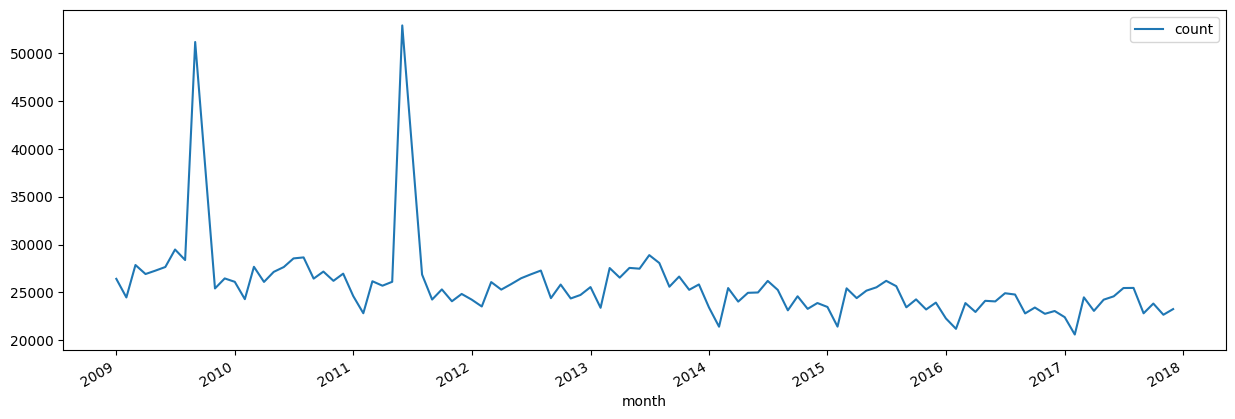

In [0]:
df_pd = df.groupby('month').count().toPandas()
df_pd.sort_values(["month", "count"]).set_index("month").plot(figsize=(15,5))

#Criação de Variáveis
Criamos as variáveis:
- wasDelayed: Variável resposta, binária: 1 se o atraso na chegada é maior ou igual a 15 minutos, 0 caso contrário;
- weekend: 1 se o voo ocorreu no final de semana, 0 caso contrário.

In [0]:
df = df.withColumn("wasDelayed", when(df.ARR_DELAY >= 15, 1.0).otherwise(0.0)) \
      .withColumn("weekday", date_format(df.FL_DATE, "EEEE"))

In [0]:
df = df.withColumn("weekend", when(df.weekday.isin(["Saturday", "Sunday"]), 1.0).otherwise(0.0)) 

In [0]:
df_save=df

In [0]:
df=df_save

#Filtro do DF

## Companhias com mais atraso
Selecionamos as 5 cias. com maior média de atrasos, entre aquelas com mais de 100.000 na base de dados

In [0]:
df.createOrReplaceTempView("voos")
spark.sql("""SELECT 
  OP_CARRIER,
  SUM(wasDelayed) AS total_atrasados,
  COUNT(*) AS total_voos,
  ROUND(SUM(wasDelayed) / COUNT(*), 4) AS proporcao_atrasados
FROM voos
GROUP BY OP_CARRIER HAVING COUNT(*) > 100000
ORDER BY proporcao_atrasados DESC""").show(10)

+----------+---------------+----------+-------------------+
|OP_CARRIER|total_atrasados|total_voos|proporcao_atrasados|
+----------+---------------+----------+-------------------+
|        B6|        24825.0|    108934|             0.2279|
|        EV|        48338.0|    226648|             0.2133|
|        MQ|        29700.0|    145948|             0.2035|
|        AA|        55738.0|    288488|             0.1932|
|        WN|       102606.0|    536932|             0.1911|
|        UA|        38811.0|    210376|             0.1845|
|        OO|        48675.0|    273916|             0.1777|
|        US|        21963.0|    132509|             0.1657|
|        DL|        51966.0|    344488|             0.1508|
+----------+---------------+----------+-------------------+



In [0]:
list_OP=['OH','EV','FL','B6','AA']
df=df.filter(df.OP_CARRIER.isin(list_OP))

In [0]:
df.groupBy("OP_CARRIER").count().orderBy("count", ascending=False).show()

+----------+------+
|OP_CARRIER| count|
+----------+------+
|        AA|288488|
|        EV|226648|
|        B6|108934|
|        FL| 61143|
|        OH| 14904|
+----------+------+



In [0]:
df.head(2)

[Row(FL_DATE=datetime.date(2009, 1, 1), OP_CARRIER='OH', OP_CARRIER_FL_NUM=6799, ORIGIN='JFK', DEST='ORD', CRS_DEP_TIME=1200.0, DEP_TIME=1200.0, DEP_DELAY=0.0, TAXI_OUT=26.0, WHEELS_OFF=1226.0, WHEELS_ON=1337.0, TAXI_IN=8.0, CRS_ARR_TIME=1353.0, ARR_TIME=1345.0, ARR_DELAY=-8.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=173.0, ACTUAL_ELAPSED_TIME=165.0, AIR_TIME=131.0, DISTANCE=740.0, CARRIER_DELAY=None, WEATHER_DELAY=None, NAS_DELAY=None, SECURITY_DELAY=None, LATE_AIRCRAFT_DELAY=None, Unnamed: 27=None, wasDelayed=0.0, weekday='Thursday', weekend=0.0),
 Row(FL_DATE=datetime.date(2009, 1, 1), OP_CARRIER='EV', OP_CARRIER_FL_NUM=4917, ORIGIN='TLH', DEST='ATL', CRS_DEP_TIME=1630.0, DEP_TIME=1621.0, DEP_DELAY=-9.0, TAXI_OUT=11.0, WHEELS_OFF=1632.0, WHEELS_ON=1709.0, TAXI_IN=7.0, CRS_ARR_TIME=1735.0, ARR_TIME=1716.0, ARR_DELAY=-19.0, CANCELLED=0.0, CANCELLATION_CODE=None, DIVERTED=0.0, CRS_ELAPSED_TIME=65.0, ACTUAL_ELAPSED_TIME=55.0, AIR_TIME=37.0, DISTANCE=223.0, 

## Aeroportos
Filtramos os aeroportos que apresentam mais atrasos na chegada, ou seja, quando eles são o destino do voo.

In [0]:
df.createOrReplaceTempView("voos")
spark.sql("""SELECT 
  DEST,
  SUM(wasDelayed) AS total_atrasados,
  COUNT(*) AS total_voos,
  ROUND(SUM(wasDelayed) / COUNT(*), 4) AS proporcao_atrasados
FROM voos
GROUP BY DEST HAVING COUNT(*) > 10000
ORDER BY proporcao_atrasados DESC""").show(10)

+----+---------------+----------+-------------------+
|DEST|total_atrasados|total_voos|proporcao_atrasados|
+----+---------------+----------+-------------------+
| ORD|         8519.0|     41224|             0.2067|
| ATL|        12439.0|     62301|             0.1997|
| DFW|        12300.0|     74009|             0.1662|
+----+---------------+----------+-------------------+



In [0]:
list_DEST=['ATL','ORD','DFW']
df=df.filter(df.DEST.isin(list_DEST))

## Remoção dos voos cancelados

In [0]:
df=df.filter(df.CANCELLED==0)

In [0]:
from pyspark.sql.functions import col, round
total_voos = df.count()

# Agrupar por ORIGIN e calcular proporção
df.groupBy("ORIGIN") \
  .count() \
  .withColumn("proporcao", round(col("count") / total_voos, 4)) \
  .orderBy("proporcao", ascending=False) \
  .show(5)

+------+-----+---------+
|ORIGIN|count|proporcao|
+------+-----+---------+
|   LGA| 5242|   0.0302|
|   LAX| 4571|   0.0263|
|   DFW| 4346|    0.025|
|   MIA| 3938|   0.0227|
|   BOS| 3789|   0.0218|
+------+-----+---------+
only showing top 5 rows


#Seleção de Variáveis
As variáveis utilizadas para previsão foram: 
- OP_CARRIER (String): Código da Cia, 
- CRS_DEP_TIME (Int): Horário previsto para a decolagem, 
- DEP_DELAY (Int): Atraso na decolagem, 
- DISTANCE (Int): Distância entre a origem e o destino e 
- weekend: Se é final de semana ou não (Binário) 
 
Para prever a variável resposta:
- wasDelayed (Binário)

In [0]:
df_save_2=df

In [0]:
col_to_drop = [
    "FL_DATE",
    "OP_CARRIER_FL_NUM",
    "DEP_TIME",
    "ARR_TIME",
    "ARR_DELAY",
    "CANCELLED",
    "CANCELLATION_CODE",
    "ACTUAL_ELAPSED_TIME",
    "AIR_TIME",
    "CARRIER_DELAY",
    "WEATHER_DELAY",
    "NAS_DELAY",
    "SECURITY_DELAY",
    "LATE_AIRCRAFT_DELAY",
    "Unnamed: 27",
    "TAXI_OUT",
    "WHEELS_OFF",
    "WHEELS_ON",
    "TAXI_IN",
    "DIVERTED",
    "ORIGIN",
    "DEST",
    "CRS_ELAPSED_TIME",
    "CRS_ARR_TIME",
    "weekday"
]

df = df.drop(*col_to_drop)

##Remoção de Dados Nulos
Após remover colunas que não serão utilizadas no modelo, removemos os dados nulos na base de dados resultante, com baixa % de valores faltantes, como mostra o retorno da função percentage_missing_rdd.

In [0]:
df = df.na.drop()

In [0]:
df.groupBy("wasDelayed").count().show()

+----------+------+
|wasDelayed| count|
+----------+------+
|       0.0|140493|
|       1.0| 33293|
+----------+------+



In [0]:
df.head(5)

[Row(OP_CARRIER='OH', CRS_DEP_TIME=1200.0, DEP_DELAY=0.0, DISTANCE=740.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1630.0, DEP_DELAY=-9.0, DISTANCE=223.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1243.0, DEP_DELAY=-10.0, DISTANCE=804.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1233.0, DEP_DELAY=-11.0, DISTANCE=147.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1455.0, DEP_DELAY=-3.0, DISTANCE=606.0, wasDelayed=0.0, weekend=0.0)]

#One Hot Encoding
One Hot Encoding foi utilizado para lidar com as variáveis categóricas, ou seja, o código da companhia (OP_CARRIER).

In [0]:
train, test = df.randomSplit([0.8, 0.2], seed=42)

In [0]:
categoricalCols=["OP_CARRIER"]
numericalCols=["CRS_DEP_TIME","DISTANCE","weekend","DEP_DELAY"]

In [0]:
df.head(5)

[Row(OP_CARRIER='OH', CRS_DEP_TIME=1200.0, DEP_DELAY=0.0, DISTANCE=740.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1630.0, DEP_DELAY=-9.0, DISTANCE=223.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1243.0, DEP_DELAY=-10.0, DISTANCE=804.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1233.0, DEP_DELAY=-11.0, DISTANCE=147.0, wasDelayed=0.0, weekend=0.0),
 Row(OP_CARRIER='EV', CRS_DEP_TIME=1455.0, DEP_DELAY=-3.0, DISTANCE=606.0, wasDelayed=0.0, weekend=0.0)]

In [0]:
indexOutCols = [ x+"Index" for x in categoricalCols ]
indexOutCols

['OP_CARRIERIndex']

In [0]:
oheOutputCols = [ x+"OHE" for x in categoricalCols ]
oheOutputCols

['OP_CARRIEROHE']

In [0]:
stringIndexer = StringIndexer(inputCols=categoricalCols,
                              outputCols=indexOutCols,
                              handleInvalid="skip") 

In [0]:
oheEncoder = OneHotEncoder(inputCols=indexOutCols,
                           outputCols=oheOutputCols)

In [0]:
assemblerInputs = numericalCols+oheOutputCols
assemblerInputs

['CRS_DEP_TIME', 'DISTANCE', 'weekend', 'DEP_DELAY', 'OP_CARRIEROHE']

In [0]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=assemblerInputs,
                               outputCol="variaveis")

#Previsão
A previsão foi feita por dois modelos: random forest e regressão logística, com e sem a otimização dos hiperparâmetros.

In [0]:
from pyspark.sql.functions import col

def classification_metrics(df, label_col="wasDelayed", prediction_col="prediction_rf"):
    TP = df.filter((col(label_col) == 1) & (col(prediction_col) == 1)).count()
    TN = df.filter((col(label_col) == 0) & (col(prediction_col) == 0)).count()
    FP = df.filter((col(label_col) == 0) & (col(prediction_col) == 1)).count()
    FN = df.filter((col(label_col) == 1) & (col(prediction_col) == 0)).count()

    total = TP + TN + FP + FN

    accuracy = (TP + TN) / total if total > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # sensibilidade
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    return {
        "acuracia": accuracy,
        "precisao": precision,
        "sensibilidade": recall,
        "especificidade": specificity
    }

In [0]:
rf = RandomForestClassifier(featuresCol="variaveis", 
                              labelCol="wasDelayed",
                              predictionCol="prediction_rf",
                              probabilityCol="probabilities_rf",
                              rawPredictionCol="rawPrediction_rf"
                              )

lr = LogisticRegression(featuresCol="variaveis", 
                              labelCol="wasDelayed",
                              predictionCol="prediction_lr",
                              probabilityCol="probabilities_lr",
                              rawPredictionCol="rawPrediction_lr",
                              threshold=0.5)


In [0]:
pipeline_rf = Pipeline(stages=[stringIndexer, oheEncoder, vecAssembler, rf])
pipeline_lr = Pipeline(stages=[stringIndexer, oheEncoder, vecAssembler, lr])

In [0]:
#prediction
predictions_rf_0 = pipeline_rf.fit(train).transform(test)
predictions_lr_0 = pipeline_lr.fit(train).transform(test)

##Cross Validation e Hiperparâmetros
Realizamos a otimização dos hiperparâmetros por meio de validação cruzada. Para Random Forest, variamos profundidade máxima (maxDepth) e número de árvores (numTrees). Para Regressão Logística, variamos número máximo de iterações (maxIter) e parâmetro de regularização (regParam).

In [0]:
evaluator_rf = BinaryClassificationEvaluator(labelCol="wasDelayed", rawPredictionCol="prediction_rf")
evaluator_lr = BinaryClassificationEvaluator(labelCol="wasDelayed", rawPredictionCol="prediction_lr")

paramGrid_rf = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.numTrees, [5, 20])
             .build())

paramGrid_lr = (ParamGridBuilder()
             .addGrid(lr.maxIter, [10, 20])
             .addGrid(lr.regParam, [0.01, 0.1])
             .build())

    
cv_rf = CrossValidator(estimator=pipeline_rf,
                    estimatorParamMaps=paramGrid_rf,
                    evaluator=evaluator_rf,
                    numFolds=3)

cv_lr = CrossValidator(estimator=pipeline_lr,
                    estimatorParamMaps=paramGrid_lr,
                    evaluator=evaluator_lr,
                    numFolds=3)

cvModel_rf = cv_rf.fit(train)
cvModel_lr = cv_lr.fit(train)

predictions_rf = cvModel_rf.transform(test)
predictions_lr = cvModel_lr.transform(test)

#Avaliação dos Modelos
A avaliação foi feita com base nas métricas: acurácia, precisão, sensibilidade e especificidade. Os resultados estão dispostos na seguinte ordem:
- Regressão Logística - Hiper-parâmetros padrão
- Floresta Aleatória - Hiper-parâmetros padrão
- Regressão Logística - Otimização de hiperparâmetros e validação cruzada
- Floresta Aleatória - Otimização de hiperparâmetros e validação cruzada

In [0]:
classification_metrics(df=predictions_lr_0,prediction_col="prediction_lr")

{'acuracia': 0.9287038109579521,
 'precisao': 0.9039002814636108,
 'sensibilidade': 0.6938271604938272,
 'especificidade': 0.9829602167403394}

In [0]:
classification_metrics(df=predictions_rf_0,prediction_col="prediction_rf")

{'acuracia': 0.9276902583111317,
 'precisao': 0.882907133243607,
 'sensibilidade': 0.7086419753086419,
 'especificidade': 0.9782903179808926}

In [0]:
classification_metrics(df=predictions_lr, prediction_col="prediction_lr")

{'acuracia': 0.9126028031970347,
 'precisao': 0.9800332778702163,
 'sensibilidade': 0.5453703703703704,
 'especificidade': 0.997433338086411}

In [0]:
classification_metrics(df=predictions_rf,prediction_col="prediction_rf")

{'acuracia': 0.9276902583111317,
 'precisao': 0.882907133243607,
 'sensibilidade': 0.7086419753086419,
 'especificidade': 0.9782903179808926}

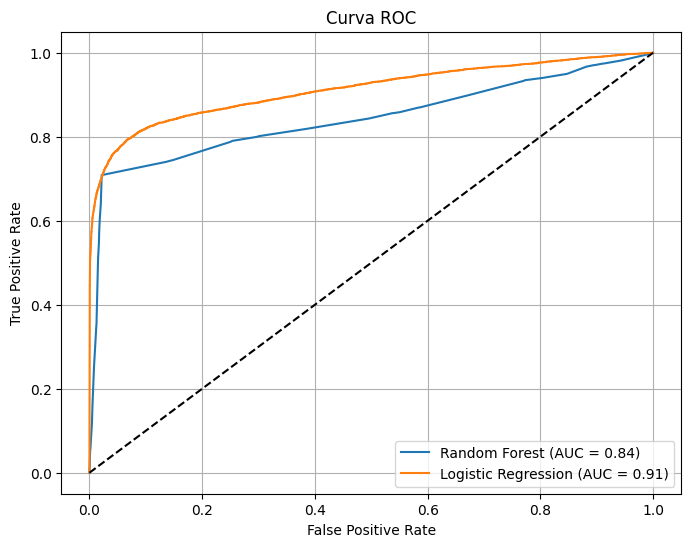

In [0]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# UDF para extrair probabilidade da classe 1
get_prob_class1 = udf(lambda v: float(v[1]), DoubleType())

# Aplicar para RF
pred_rf = predictions_rf.withColumn("prob_rf", get_prob_class1(col("probabilities_rf")))

# Aplicar para LR
pred_lr = predictions_lr.withColumn("prob_lr", get_prob_class1(col("probabilities_lr")))

import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Converter para Pandas
pdf_rf = pred_rf.select("wasDelayed", "prob_rf").toPandas()
pdf_lr = pred_lr.select("wasDelayed", "prob_lr").toPandas()

# ROC Curve para RF
fpr_rf, tpr_rf, _ = roc_curve(pdf_rf["wasDelayed"], pdf_rf["prob_rf"])
auc_rf = auc(fpr_rf, tpr_rf)

# ROC Curve para LR
fpr_lr, tpr_lr, _ = roc_curve(pdf_lr["wasDelayed"], pdf_lr["prob_lr"])
auc_lr = auc(fpr_lr, tpr_lr)

# Plotar
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # linha aleatória
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()



O modelo escolhido foi Random Forest com otimização de hiperparâmetros. A sensibilidade foi maior que os modelos de regressão logística, ou seja, o modelo indentifica de forma mais eficaz os atrasos. No contexto do problema, é mais importante que o modelo identifique os atrasos do que os voos que não vão atrasar. Em outras palavras, falsos negativos são mais críticos do que falsos positivos.

Dessa forma, o modelo suporte a decisão dos aeroportos em relação ao remanejamento de rotas ou mudanças na ordem dos pousos.

#Obrigado